Loaded 2622 rows (without noise)


100%|████████████████████| 16/16 [00:00<00:00, 111.81it/s]


Prepared 2622 sequences
Train size: 2097, Test size: 525


C:\Users\ved\Desktop\Speech-Completition-Prediction\python\.venv\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape     ┃  Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ masking_2 (Masking)   │ (None, None,     │        0 │
│                       │ 384)             │          │
├───────────────────────┼──────────────────┼──────────┤
│ lstm_2 (LSTM)         │ (None, 128)      │  262,656 │
├───────────────────────┼──────────────────┼──────────┤
│ dense_4 (Dense)       │ (None, 64)       │    8,256 │
├───────────────────────┼──────────────────┼──────────┤
│ dense_5 (Dense)       │ (None, 10)       │      650 │
└───────────────────────┴──────────────────┴──────────┘

 Total params: 271,562 (1.04 MB)

 Trainable params: 271,562 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - accuracy: 0.1980 - loss: 2.1314 - val_accuracy: 0.5238 - val_loss: 1.1404
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.5735 - loss: 1.0707 - val_accuracy: 0.7086 - val_loss: 0.6928
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.7486 - loss: 0.6656 - val_accuracy: 0.7695 - val_loss: 0.5893
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step - accuracy: 0.8267 - loss: 0.4783 - val_accuracy: 0.7371 - val_loss: 0.5856
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - accuracy: 0.8512 - loss: 0.3633 - val_accuracy: 0.8629 - val_loss: 0.3321
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.8789 - loss: 0.3014 - val_accuracy: 0.8552 - val_loss: 0.3045
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.8664 - loss: 0.3171 - val_accuracy: 0.8514 - val_loss: 0.3964
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - accuracy: 0.8959 - loss: 0.2665 - val_accu

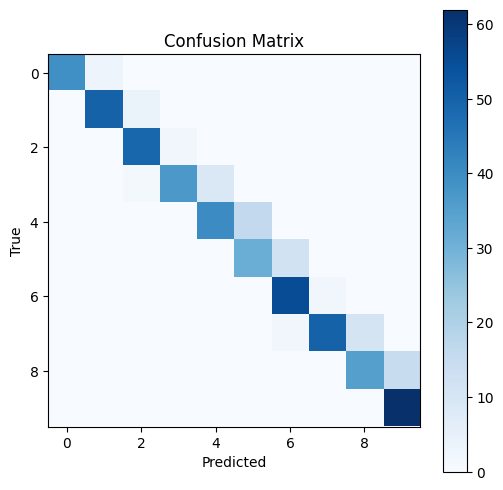

In [5]:
# Import
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Params
INPUT_PATH = "./progress_added.csv"
NUM_CLASSES = 10   # progress bins: 0 to 4
EMBED_DIM = 384   # MiniLM embedding size

# Load data
df = pd.read_csv(INPUT_PATH)
df = df[df["cluster"] != -1]
df = df[df["text"].notnull() & df["text"].str.strip().astype(bool)]
print(f"Loaded {len(df)} rows (without noise)")

# Prepare sequences

# convert embedding string to list
df["embedding"] = df["embedding"].apply(lambda x: np.array(eval(x), dtype=np.float32))

X = []
y = []

for file_name, group in tqdm(df.groupby("file")):
    group = group.sort_values("start_sec")
    
    sequence = []
    for i, row in group.iterrows():
        sequence.append(row["embedding"])
        X.append(sequence.copy())
        y.append(int(row["progress_label"]))

print(f"Prepared {len(X)} sequences")

# Pad sequences
X_padded = pad_sequences(X, dtype='float32', padding='post')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# Build LSTM model
model = models.Sequential([
    layers.Masking(mask_value=0.0, input_shape=(None, EMBED_DIM)),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train
history = model.fit(
    X_train, np.array(y_train),
    validation_data=(X_test, np.array(y_test)),
    epochs=10,
    batch_size=32
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, np.array(y_test))
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification report
y_pred = model.predict(X_test).argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()
